<a href="https://colab.research.google.com/github/PGM-Lab/2023-probai-private/blob/main/Day2-AfterLunch/notebooks/bayesian_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup
Let's begin by installing and importing the modules we'll need.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import types
import matplotlib.pyplot as plt
from pyro.infer import Predictive
import pyro
from pyro.distributions import Normal, Uniform, Delta, Gamma, Binomial
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import torch.distributions.constraints as constraints
import pyro.optim as optim
from pyro.contrib.autoguide import AutoNormal
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# for CI testing
pyro.set_rng_seed(1)
pyro.enable_validation(True)

# 1. Dataset 

The following example is taken from \[1\].  We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable *rugged* in the dataset) and its GDP per capita. In particular, it was noted by the authors in \[1\] that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the data \[2\] and investigate this relationship.  We will be focusing on three features from the dataset:
  - `rugged`: quantifies the Terrain Ruggedness Index
  - `cont_africa`: whether the given nation is in Africa
  - `rgdppc_2000`: Real GDP per capita for the year 2000
 
  
We will take the logarithm for the response variable GDP as it tends to vary exponentially.

In [2]:
DATA_URL = "https://raw.githubusercontent.com/pyro-ppl/brmp/master/brmp/examples/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df.sample(frac=1)
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
df = df[["cont_africa", "rugged", "rgdppc_2000"]]

# Divide the data into predictors and response and store the data in tensors organized in a dictionary with one
# element for african and non-african nations, respectively.
data = torch.tensor(df.values, dtype=torch.float)
x_data = {'non-african': data[data[:, 0] == 0, 1].reshape(-1,1), 'african': data[data[:, 0] == 1, 1].reshape(-1,1)}
y_data = {'non-african': data[data[:, 0] == 0, -1], 'african': data[data[:, 0] == 1, -1]}

print(f"Number of african countries: {x_data['african'].shape[0]}")
print(f"Number of non-african countries: {x_data['non-african'].shape[0]}")

Number of african countries: 49
Number of non-african countries: 121


In [3]:
# Display first 10 entries 
display(df[0:10])

,cont_africa,rugged,rgdppc_2000
199,0,0.756,8.084006
69,0,1.098,10.154169
233,1,1.194,7.823732
39,1,0.224,7.362409
90,0,2.150,7.826535
67,0,1.396,8.507122
73,0,0.568,10.178542
211,0,2.620,8.781149
188,0,1.750,8.432566
179,0,0.914,9.423362


In [4]:
def prepare_figure(title='Scatter plot of data', x_data_: dict = None, y_data_: dict = None):
    """
    Plot the data and return the figure axis for possible subsequent additional plotting.
    :param title: Title of the plot
    :param x_data_: dictionary with data for the prdictor variable
    :param y_data_: dictionary with data for the response variable.
    :return: Figure axis.
    """
    if x_data_ is None and y_data_ is None:
        x_data_ = x_data
        y_data_ = y_data

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6), sharey=True)
    fig.suptitle(title, fontsize=16)

    for idx, cont in enumerate(x_data):
        ax[idx].scatter(x_data_[cont], y_data_[cont], c='black')
        ax[idx].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)",
                    title=f"{cont} nations")

    return ax

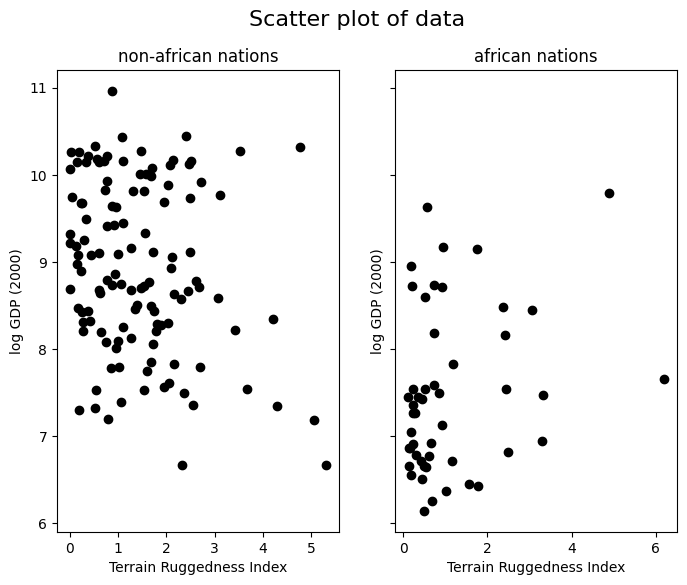

In [5]:
# Let's display the data
prepare_figure('Scatter plot of data')
plt.show()

# 1. Linear regression

Linear regression is one of the most commonly used supervised learning tasks in machine learning. Suppose we are given a dataset $\mathcal{D}$ of the form

$$ \mathcal{D}  = \{ (X_i, y_i) \} \qquad \text{for}\qquad i=1,2,...,N$$

The goal of linear regression is to fit a function to the data of the form:

$$ y = w X + b + \epsilon, $$

where $w$ and $b$ are learnable parameters and $\epsilon$ represents observation noise. Specifically $w$ is a matrix of weights and $b$ is a bias vector.

Let's first implement linear regression in PyTorch and learn point estimates for the parameters $w$ and $b$.  Then we'll see how to incorporate uncertainty into our estimates.

## 2.2 Model specification
We would like to predict log GDP per capita of a nation as a function of whether the nation is in Africa and its Terrain Ruggedness Index. As indicated by the data partitioning above, we will make one linear regression model for african and non-african nations, respectively. 

To sprcify our regression model, we will define a specific object encapsulating the model.  Our input `x_data` is a tensor of size $N \times 1$ and our output `y_data` is a tensor of size $N \times 1$.  The method `predict(self,x_data)` defines a linear transformation of the form $Xw + b$ where $w$ is the weight matrix and $b$ is the additive bias.

The parameters of the model are defined using ``torch.nn.Parameter``, and will be learned during training.

In [6]:
class RegressionModel():
    def __init__(self):
        self.w = torch.nn.Parameter(torch.zeros(1, 1))
        self.b = torch.nn.Parameter(torch.zeros(1, 1))

    def params(self):
        return {"b":self.b, "w": self.w}

    def predict(self, x_data):
        return (self.b + torch.mm(self.w, torch.t(x_data))).squeeze(0)

In [7]:
regression_model = RegressionModel()

## 2.3 Training
We will use the mean squared error (MSE) as our loss and Adam as our optimizer. We would like to optimize the parameters of the `regression_model` neural net above. We will use a somewhat large learning rate of `0.05` and run for 1000 iterations.

In [8]:
def least_squares_solution(x_data, y_data, regression_model, verbose=True):
    loss_fn = torch.nn.MSELoss(reduction='sum')
    optim = torch.optim.Adam(regression_model.params().values(), lr=0.05)
    num_iterations = 1000

    param = {}
    for cont in x_data.keys():
        param[cont] = {}
        if verbose:
            print(f"Learning model for {cont} nations")
        for j in range(num_iterations):
            # run the model forward on the data
            y_pred = regression_model.predict(x_data[cont])
            # calculate the mse loss
            loss = loss_fn(y_pred, y_data[cont])
            # initialize gradients to zero
            optim.zero_grad()
            # backpropagate
            loss.backward()
            # take a gradient step
            optim.step()
            if (j + 1) % 500 == 0 and verbose:
                print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

        # Stored the learned parameters
        param[cont]['w'] = np.r_[regression_model.params()['b'].detach().numpy().copy().flatten(),
                      np.transpose(regression_model.params()['w'].detach().numpy()).copy().flatten()]
    # Inspect learned parameters
    if verbose:
        print("Learned parameters:")
        for cont in param.keys():
            print(f"{cont}: weights = {param[cont]['w']}")

    return param

In [9]:
# Learn the model
regression_model = RegressionModel()
model_lr = least_squares_solution(x_data, y_data, regression_model)

Learning model for non-african nations
[iteration 0500] loss: 124.0176
[iteration 1000] loss: 108.7801
Learning model for african nations
[iteration 0500] loss: 39.1070
[iteration 1000] loss: 39.1017
Learned parameters:
non-african: weights = [ 9.220676   -0.20161663]
african: weights = [7.275192   0.19053152]


## 2.4 Evaluating the model

We now plot the regression line learned for african and non-afrian nations relating the rugeedness index with the GDP of the country.

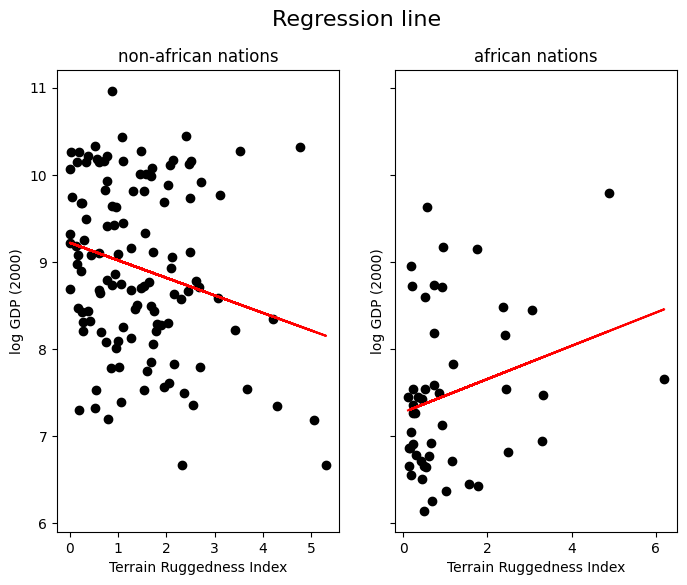

In [10]:
ax = prepare_figure(title='Regression line')
for idx, cont in enumerate(x_data.keys()):
    ax[idx].plot(x_data[cont], model_lr[cont]['w'][0] + x_data[cont] * model_lr[cont]['w'][1], 'r') 
plt.show()

## 2.5 The relationship between ruggedness and log GPD

Using this analysis, we can estimate the relationship between ruggedness and log GPD. As can be seen, this relationship is positive for African nations, but negative for Non African Nations.

In [11]:
print(f"Slope for non-african nations: {model_lr['non-african']['w'][1]}")
print(f"Slope for african nations: {model_lr['african']['w'][1]}")

Slope for non-african nations: -0.20161662995815277
Slope for african nations: 0.19053152203559875


# 3. Bayesian Linear Regression


[Bayesian modeling](http://mlg.eng.cam.ac.uk/zoubin/papers/NatureReprint15.pdf) offers a systematic framework for reasoning about model uncertainty. Instead of just learning point estimates, we're going to learn a _distribution_ over parameters that are consistent with the observed data.

In order to make our linear regression Bayesian, we need to put priors on the model parameters $w$, $b$ and $\theta$. These are distributions that represent our prior belief about reasonable values for these parameters (before observing any data).

A graphical representation would be as follows:

<img src="https://github.com/PGM-Lab/probai-2021-pyro/raw/main/Day3/Figures/BayesianLinearRegressionPGM.png" width=800>

## 3.1 Model

We now have all the ingredients needed to specify our model. Note the priors that we are using for the different latent variables in the model. The prior on the intercept parameter is very flat as we would like this to be learnt from the data. We are using a weakly regularizing prior on the regression coefficients to avoid overfitting to the data.

We use the `obs` argument to the `pyro.sample` statement to condition on the observed data `y_data` with a learned observation noise parameter.

In [12]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

In [13]:
def model(x_data_, y_data_):
    # weight/slope prior
    s = pyro.sample("s", Normal(0, 1))

    # bias/intercept prior
    b = pyro.sample("b", Normal(0., 1000.))

    # Introduce a Gamma random variable called "theta" for modelling the precision
    theta = pyro.sample("theta", Gamma(1., 1.))

    # Compute the predicion mean
    mean = (b + x_data_ * s).squeeze(-1)
    pyro.deterministic("predictive_mean", mean)

    with pyro.plate("plate_x", len(x_data_)):
        # Introduce a Normal distribution and condition on the observed data
        pyro.sample("y", Normal(loc=mean, scale=torch.sqrt(1. / theta)), obs=y_data_)

    return mean

In [14]:
pyro.render_model(model, model_args=(x_data['african'], y_data['african']), render_distributions=True)

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

## 2.2 Guide

In order to do inference we're going to need a guide, i.e. a variational family of distributions.  

### Autoguides
We will use Pyro's [autoguide library](http://docs.pyro.ai/en/dev/contrib.autoguide.html) to automatically place Gaussians with diagonal covariance on all of the distributions in the model.  Under the hood, this defines a `guide` function with `Normal` distributions with learnable parameters corresponding to each `sample()` in the model.  Autoguide also supports learning MAP estimates with `AutoDelta` or composing guides with `AutoGuideList` (see the [docs](http://docs.pyro.ai/en/dev/contrib.autoguide.html) for more information). 

### Manually defined guides

Alternatively, we can also define our own guide

In [15]:
def customized_guide(x_data, y_data):
    q_b_loc = pyro.param("q_loc_b", torch.tensor(0.0))
    q_b_scale = pyro.param("q_scale_b", torch.tensor(1.0), constraint=constraints.positive)
    pyro.sample("b", Normal(q_b_loc, q_b_scale))

    q_s_loc = pyro.param("q_loc_s", torch.tensor(0.0))
    q_s_scale = pyro.param("q_scale_s", torch.tensor(1.0), constraint=constraints.positive)
    pyro.sample("s", Normal(q_s_loc, q_s_scale))

    q_theta_alpha = pyro.param("q_alpha_theta", torch.tensor(1.0), constraint=constraints.positive)
    q_theta_beta = pyro.param("q_beta_theta", torch.tensor(1.0), constraint=constraints.positive)
    pyro.sample("theta", Gamma(q_theta_alpha, q_theta_beta))

## 2.3 Inference

To do inference we'll use stochastic variational inference (SVI) (for an introduction to SVI, see [SVI Part I](svi_part_i.ipynb)). Just like in the non-Bayesian linear regression, each iteration of our training loop will take a gradient step, with the difference that in this case, we'll use the ELBO objective instead of the MSE loss by constructing a `Trace_ELBO` object that we pass to `SVI`. 

Here `Adam` is a thin wrapper around `torch.optim.Adam` (see [here](svi_part_i.ipynb#Optimizers) for a discussion). To take an ELBO gradient step we simply call the step method of SVI. Notice that the data argument we pass to step will be passed to both model() and guide().  The complete training loop is as follows:

In [16]:
def train(x_data, y_data, model, guide_=None, num_iterations=1500, verbose=True):
    optim = Adam({"lr": 0.1})
    param = {}
    for cont in x_data.keys():
        if guide_ is None:
            guide = AutoNormal(model)
        else:
            guide=guide_
        svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=10)
        pyro.clear_param_store()

        for j in range(num_iterations):
            # calculate the loss and take a gradient step
            loss = svi.step(x_data[cont], y_data[cont])
            if j % 500 == 0:
                print("[iteration %04d] loss: %.4f" % (j, loss / len(data)))
        param[cont] = {'vi_parameters': pyro.get_param_store().get_state(),
                       'guide': guide}

    return param

In [17]:
# Insert you own guide if you like
param = train(x_data, y_data, model, guide_=None)

[iteration 0000] loss: 30.3888
[iteration 0500] loss: 1.2969
[iteration 1000] loss: 1.0564
[iteration 0000] loss: 11.6487
[iteration 0500] loss: 0.4585
[iteration 1000] loss: 0.4557


In [18]:
# Print the parameters
for cont in param.keys():
    header = f"\nThe parameters for {cont} nations:"
    print(header)
    print(f"-"*len(header))
    for name, value in param[cont]['vi_parameters']['params'].items():
        print(f"{name:<25}: {value.detach().numpy()}")


The parameters for non-african nations:
----------------------------------------
AutoNormal.locs.s        : -0.19629241526126862
AutoNormal.scales.s      : -3.029761552810669
AutoNormal.locs.b        : 9.250144958496094
AutoNormal.scales.b      : -2.3883347511291504
AutoNormal.locs.theta    : 0.05711764469742775
AutoNormal.scales.theta  : -1.9720373153686523

The parameters for african nations:
------------------------------------
AutoNormal.locs.s        : 0.24825941026210785
AutoNormal.scales.s      : -2.6623072624206543
AutoNormal.locs.b        : 7.303408622741699
AutoNormal.scales.b      : -1.993133306503296
AutoNormal.locs.theta    : 0.17224456369876862
AutoNormal.scales.theta  : -1.5558291673660278


# Model evaluation

For model evaluation we rely on Pyro's Predictive class, which allows for easy sampling of the model parameters and subsequent estimations of the posterior predictive distribution. 

In [19]:
x_test = np.linspace(0, 6, 100)
svi_samples = {}
for cont in x_data.keys():
    pyro.get_param_store().set_state(param[cont]['vi_parameters'])
    predictive = pyro.infer.Predictive(model, guide=param[cont]['guide'], num_samples=1000)
    #svi_samples[cont] = predictive(x_data[cont], None)
    svi_samples[cont] = predictive(torch.tensor(x_test), None)

Disregarding our uncertainty estimates, we first plot the regression line defined by the predictive mean.

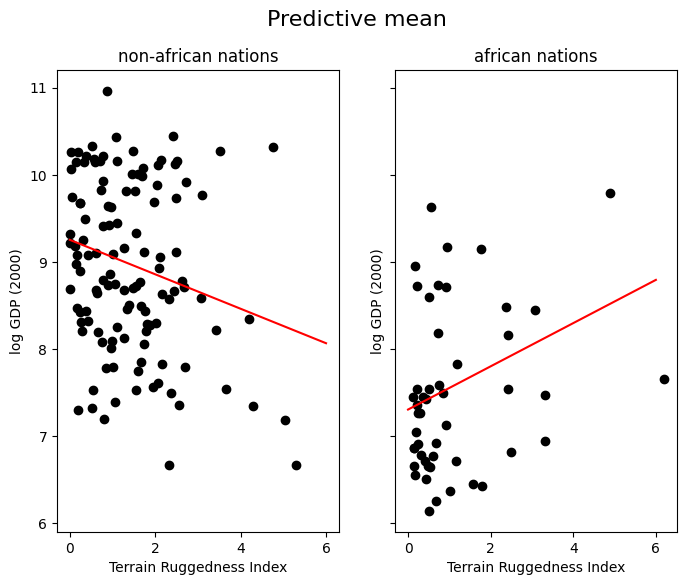

In [20]:
ax = prepare_figure('Predictive mean')
for idx, cont in enumerate(x_data.keys()):
    y_predictive_mean = torch.squeeze(svi_samples[cont]['predictive_mean']).detach().numpy()
    ax[idx].plot(x_test, np.mean(y_predictive_mean, axis=0), color='r')
plt.show()

If we lso take the uncertainty over the bias and slope into account, we can express the uncertain in our regression line. Below this is shown as the 95% CI around the mean.

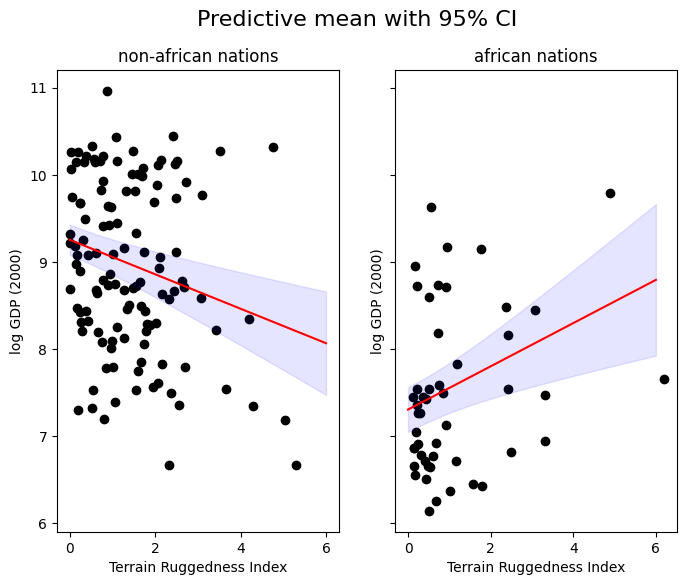

In [21]:
ax = prepare_figure('Predictive mean with 95% CI')
for idx, cont in enumerate(x_data.keys()):
    predictive_mean = torch.squeeze(svi_samples[cont]['predictive_mean']).detach().numpy()
    predictive_std = np.std(predictive_mean, axis=0)
    ax[idx].fill_between(x_test,
                         np.mean(predictive_mean, axis=0) - 2 * predictive_std,
                         np.mean(predictive_mean, axis=0) + 2 * predictive_std,
                         color='b',
                         alpha=0.1)
    ax[idx].plot(x_test, np.mean(predictive_mean, axis=0), color='r')

plt.show()

If we also take the uncertainty in the response variable into account, i.e., sigma, we get the following 95% CI.

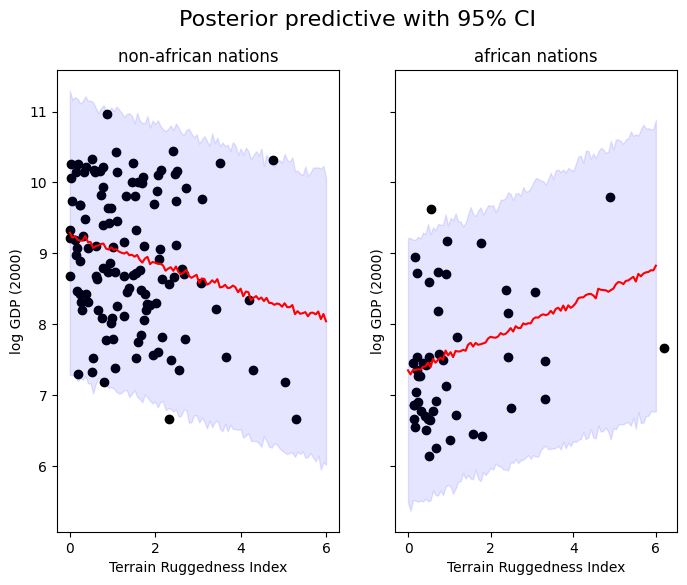

In [22]:
ax = prepare_figure('Posterior predictive with 95% CI')
for idx, cont in enumerate(x_data.keys()):
    y_predictive_mean = torch.squeeze(svi_samples[cont]['y']).detach().numpy()
    y_predictive_std = np.std(y_predictive_mean, axis=0)
    ax[idx].fill_between(x_test,
                         np.mean(y_predictive_mean, axis=0) - 2 * y_predictive_std,
                         np.mean(y_predictive_mean, axis=0) + 2 * y_predictive_std,
                         color='b',
                         alpha=0.1)
    ax[idx].plot(x_test, np.mean(y_predictive_mean, axis=0), color='r')

plt.show()

Lastly, we can revisit the question about the relationship between GDP and ruggedness by plotting the distribution of the slope for ruggedness for african and nn-african nations.

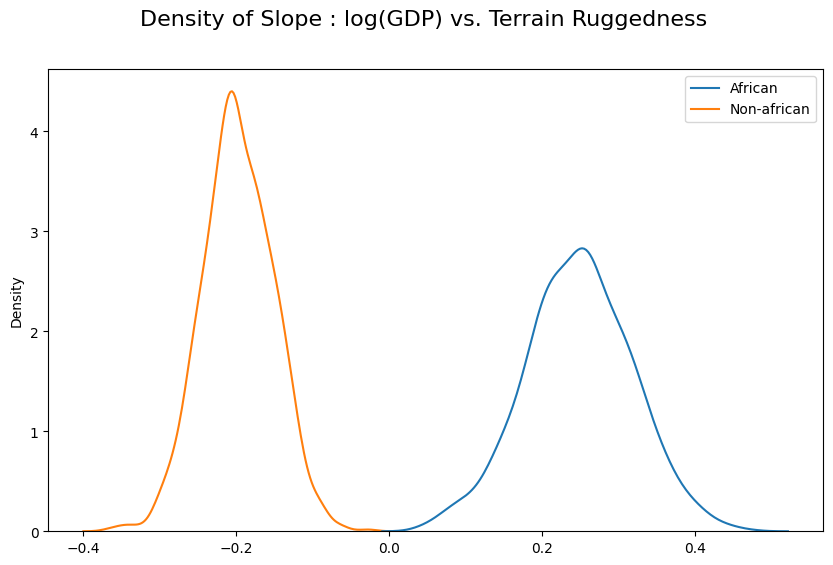

In [23]:
fig = plt.figure(figsize=(10, 6))
sns.kdeplot(pd.DataFrame({'African': svi_samples['african']['s'].squeeze().tolist(), 'Non-african': svi_samples['non-african']['s'].squeeze().tolist()}))
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness", fontsize=16)
plt.show()

### References
  1. McElreath, D., *Statistical Rethinking, Chapter 7*, 2016
  2. Nunn, N. & Puga, D., *[Ruggedness: The blessing of bad geography in Africa"](https://diegopuga.org/papers/rugged.pdf)*, Review of Economics and Statistics 94(1), Feb. 2012